# Exploration analysis in dataset of recorded incidents ("alarms") of broken fridges

#### Rafael Barrera - Camilo Gómez

## In this notebook we perform a data exploration for each of the characteristics provided by the database and from which each alarm is determined.

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

### Upload database

In [ ]:
df=pd.read_csv('CPT_PREDICTIVE_PPM.csv',encoding_errors='ignore')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,12,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Basic features of database

In [ ]:
df.columns

Index(['Work Order Number', 'Site Number', 'Site Type', 'Date Created',
       'Date Completed', 'Provider Name', 'WO Current Status',
       'Asset Category', 'Problem Type Name', 'Requested By', 'WO Priority',
       'Manufacturer', 'Asset In-Service Date', 'Level 1 Organization Name',
       'Site Zipcode', 'Sales Sq. Ft.', 'Asset Barcode', 'Client Product Name',
       'Asset Type', 'Asset Status'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609989 entries, 0 to 609988
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Work Order Number          609989 non-null  int64  
 1   Site Number                609989 non-null  object 
 2   Site Type                  609989 non-null  object 
 3   Date Created               609989 non-null  object 
 4   Date Completed             577602 non-null  object 
 5   Provider Name              609989 non-null  object 
 6   WO Current Status          609989 non-null  object 
 7   Asset Category             609989 non-null  object 
 8   Problem Type Name          609989 non-null  object 
 9   Requested By               527644 non-null  object 
 10  WO Priority                609989 non-null  object 
 11  Manufacturer               609989 non-null  object 
 12  Asset In-Service Date      506751 non-null  object 
 13  Level 1 Organization Name  60

## Calculation of the time needed to repair an asset per month and per hour

In [ ]:
df['Date Created']=pd.to_datetime(df['Date Created'])
df['Date Completed']=pd.to_datetime(df['Date Completed'])
df['Asset In-Service Date']=pd.to_datetime(df['Asset In-Service Date'])

In [ ]:
tf=[]
dc=df['Date Completed'].isnull().values
aid=df['Asset In-Service Date'].isnull().values
for i in range(df.shape[0]):
  if dc[i]==aid[i]:
    tf.append(dc[i])
  else:
    tf.append(True)
tf=np.array(tf)

In [ ]:
df_t=df[~tf]
time_in_service=[]
time_reparation=[]
for i in range(df_t.shape[0]):
  time_in_service.append(np.timedelta64(df_t['Date Created'].values[i]-df_t['Asset In-Service Date'].values[i],'h').astype(int))
  time_reparation.append(np.timedelta64(df_t['Date Completed'].values[i]-df_t['Date Created'].values[i],'h').astype(int))
time_in_service=np.array(time_in_service)
time_reparation=np.array(time_reparation)

In [ ]:
indx_date_del=np.unique(np.sort(np.append(np.where(time_in_service<0)[0],np.where(time_reparation<0)[0])))

In [ ]:
mask=np.array([True for i in range(df_t.shape[0])])
for i in indx_date_del:
  mask[i]=False

In [ ]:
df_tsr=pd.DataFrame(data=np.hstack((np.array([time_in_service[mask]]).T,np.array([time_reparation[mask]]).T)),columns=(['Time Service (h)','Time Reparation (h)']))

In [ ]:
df_tn=df_t[mask].reset_index().join(df_tsr)

In [ ]:
nw=[]
MyC=np.arange(7)
for i in range(7):
  nwl=[df['Site Type'].unique()[i],MyC[i]]
  nw.append(nwl)

In [ ]:
df_stc=pd.DataFrame(data=np.array(nw),columns=['Site Type','Site Type Code'])
df_tn=pd.merge(df_tn,df_stc)
df_tn['Site Type Code']=df_tn['Site Type Code'].astype(int)

In [ ]:
interval=np.linspace(0,df_tn['Time Reparation (h)'].values.max()+1,22)

ni=[]
for i in range(interval.shape[0]-1):
  nu=[]
  for j in df_tn['Time Reparation (h)'].values:
    nu.append(interval[i]<=j<interval[i+1])
  ni.append(np.unique(nu,return_counts=True))

<Figure size 504x360 with 0 Axes>

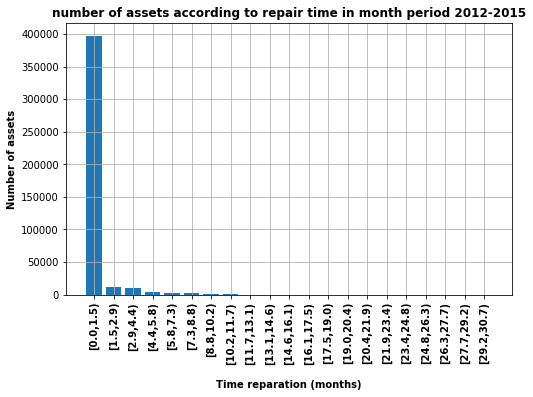

In [ ]:
plt.figure(figsize=(7,5))
labels=[''.join(['[',str(np.around(interval/720,1)[i]),',',str(np.around(interval/720,1)[i+1]),')']) for i in range(interval.shape[0]-1)]
plt.figure(figsize=(8,5))
plt.bar(labels,[i[1][1] for i in ni])
plt.xticks(labels,rotation=90,weight='bold')
plt.xlabel('Time reparation (months)',fontsize=10,weight='bold',labelpad=15)
plt.ylabel('Number of assets',fontsize=10,weight='bold')
plt.grid(True)
plt.title('number of assets according to repair time in month period 2012-2015',fontsize=12,weight='bold')
plt.show()

In [ ]:
C=[]
for i in df_tn['Time Reparation (h)'].value_counts().sort_index().index:
  val=df_tn[df_tn['Time Reparation (h)']==i]['Site Type Code'].values[0]
  C.append(val)

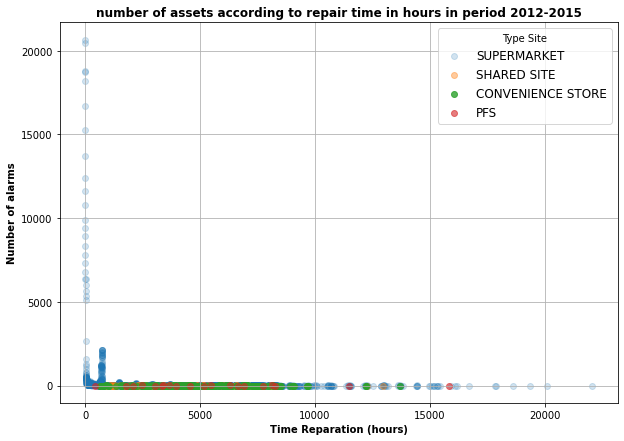

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_tn['Time Reparation (h)'].value_counts().sort_index().index[np.where(np.array(C)==0)[0]],\
            df_tn['Time Reparation (h)'].value_counts().sort_index().values[np.where(np.array(C)==0)[0]],alpha=0.2)
plt.scatter(df_tn['Time Reparation (h)'].value_counts().sort_index().index[np.where(np.array(C)==1)[0]],\
            df_tn['Time Reparation (h)'].value_counts().sort_index().values[np.where(np.array(C)==1)[0]],alpha=0.4)
plt.scatter(df_tn['Time Reparation (h)'].value_counts().sort_index().index[np.where(np.array(C)==3)[0]],\
            df_tn['Time Reparation (h)'].value_counts().sort_index().values[np.where(np.array(C)==3)[0]],alpha=0.8)
plt.scatter(df_tn['Time Reparation (h)'].value_counts().sort_index().index[np.where(np.array(C)==2)[0]],\
            df_tn['Time Reparation (h)'].value_counts().sort_index().values[np.where(np.array(C)==2)[0]],alpha=0.6)
plt.legend(['SUPERMARKET','SHARED SITE','CONVENIENCE STORE','PFS'],title='Type Site',fontsize=12)
plt.title('number of assets according to repair time in hours in period 2012-2015',fontsize=12,weight='bold')
plt.xlabel('Time Reparation (hours)',weight='bold')
plt.ylabel('Number of alarms',weight='bold')
plt.grid()
plt.show()

## Calculation of the service time of an asset per month and per hour

In [ ]:
ni=[]
for i in range(interval.shape[0]-1):
  nu=[]
  for j in df_tn['Time Service (h)'].values:
    nu.append(interval[i]<=j<interval[i+1])
  ni.append(np.unique(nu,return_counts=True))

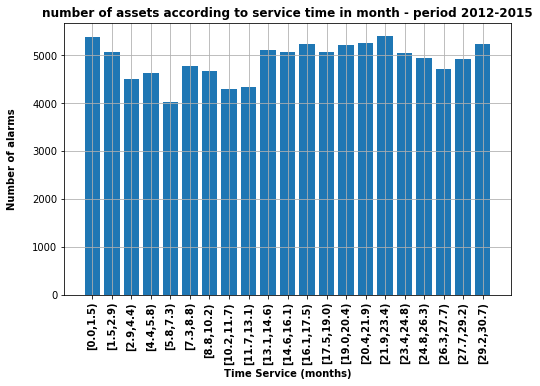

In [ ]:
labels=[''.join(['[',str(np.around(interval/720,1)[i]),',',str(np.around(interval/720,1)[i+1]),')']) for i in range(interval.shape[0]-1)]
plt.figure(figsize=(8,5))
plt.bar(labels,[i[1][1] for i in ni])
plt.xticks(labels,rotation=90,weight='bold')
plt.xlabel('Time Service (months)',weight='bold')
plt.ylabel('Number of alarms',weight='bold',labelpad=15)
plt.title('number of assets according to service time in month - period 2012-2015',fontsize=12,weight='bold')
plt.grid(True)
plt.show()

In [ ]:
C=[]
for i in df_tn['Time Service (h)'].value_counts().sort_index().index:
  val=df_tn[df_tn['Time Service (h)']==i]['Site Type Code'].values[0]
  C.append(val)

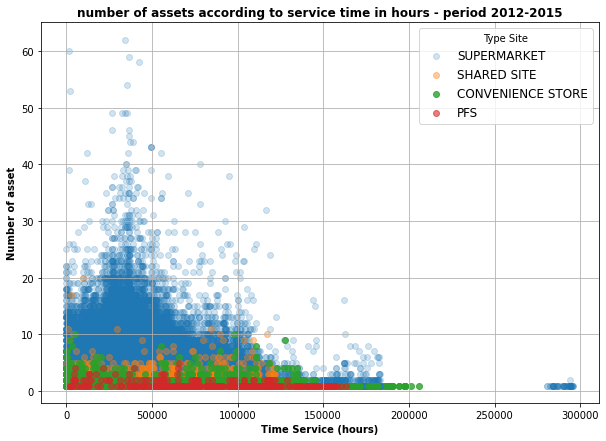

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_tn['Time Service (h)'].value_counts().sort_index().index[np.where(np.array(C)==0)[0]],\
            df_tn['Time Service (h)'].value_counts().sort_index().values[np.where(np.array(C)==0)[0]],alpha=0.2)
plt.scatter(df_tn['Time Service (h)'].value_counts().sort_index().index[np.where(np.array(C)==1)[0]],\
            df_tn['Time Service (h)'].value_counts().sort_index().values[np.where(np.array(C)==1)[0]],alpha=0.4)
plt.scatter(df_tn['Time Service (h)'].value_counts().sort_index().index[np.where(np.array(C)==3)[0]],\
            df_tn['Time Service (h)'].value_counts().sort_index().values[np.where(np.array(C)==3)[0]],alpha=0.8)
plt.scatter(df_tn['Time Service (h)'].value_counts().sort_index().index[np.where(np.array(C)==2)[0]],\
            df_tn['Time Service (h)'].value_counts().sort_index().values[np.where(np.array(C)==2)[0]],alpha=0.6)
plt.legend(['SUPERMARKET','SHARED SITE','CONVENIENCE STORE','PFS'],title='Type Site',fontsize=12)
plt.xlabel('Time Service (hours)',weight='bold')
plt.ylabel('Number of asset',weight='bold')
plt.title('number of assets according to service time in hours - period 2012-2015',fontsize=12,weight='bold')
plt.grid()
plt.show()

## Exploration of the behavior of alarms in the same day for every year by type of site

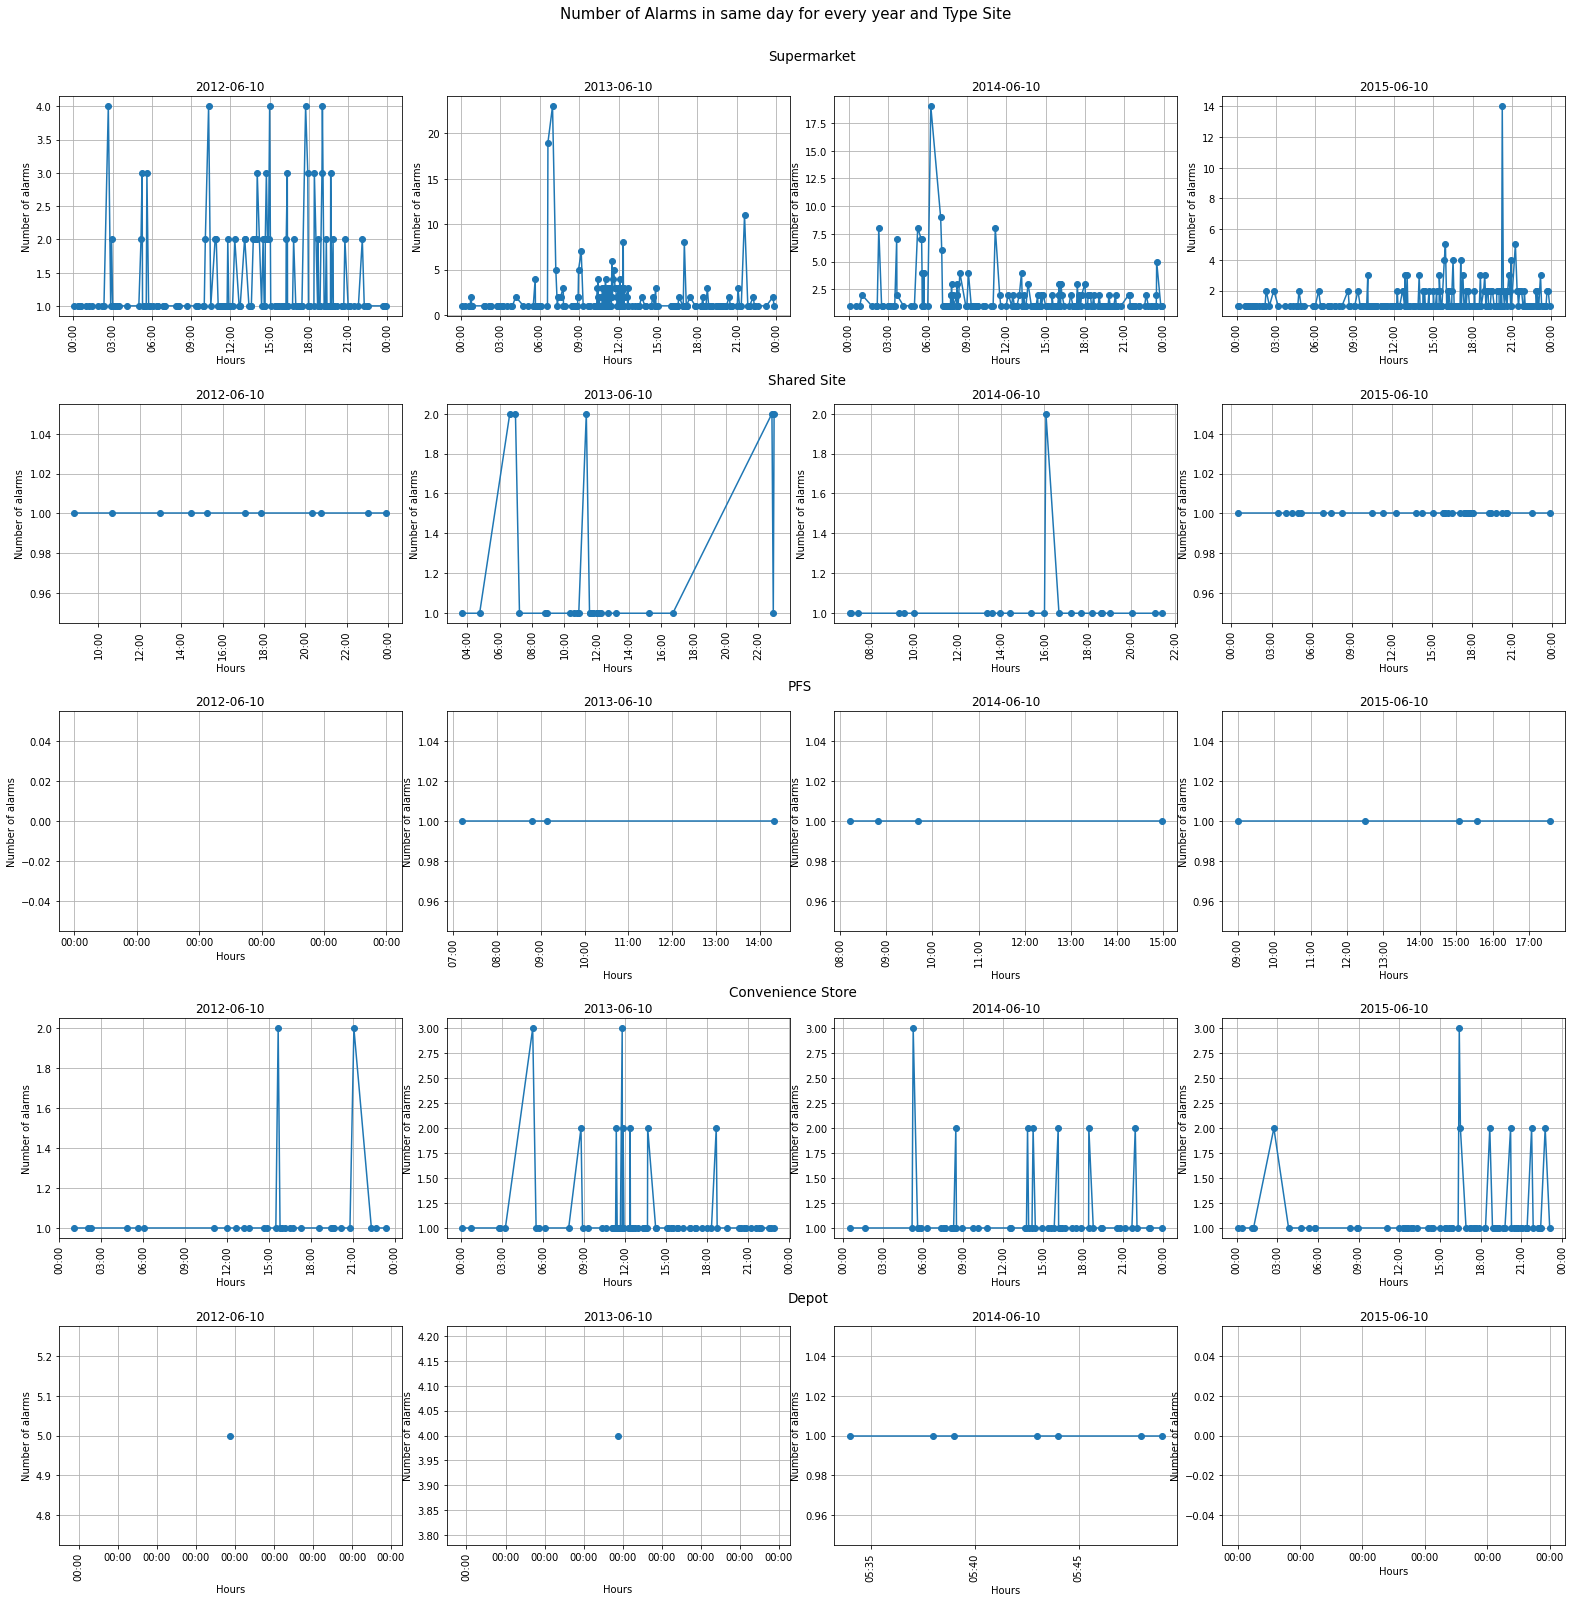

In [ ]:
dates=[['2012-06-10','2012-06-11'],['2013-06-10','2013-06-11'],['2014-06-10','2014-06-11'],['2015-06-10','2015-06-11']]
sites=df['Site Type'].unique()[:5]
fig, ax = plt.subplots(5,4,figsize=(27,25))
plt.subplots_adjust(hspace=0.4,wspace=0.13,top=0.93)
plt.suptitle('Number of Alarms in same day for every year and Type Site ', fontsize=15)
plt.figtext(0.49,0.95,'Supermarket',fontsize=13.5)
plt.figtext(0.49,0.77,'Shared Site',fontsize=13.5)
plt.figtext(0.5,0.60,'PFS',fontsize=13.5)
plt.figtext(0.47,0.43,'Convenience Store',fontsize=13.5)
plt.figtext(0.5,0.26,'Depot',fontsize=13.5)
myFmt = mdates.DateFormatter('%H:%M')
for i in range(sites.shape[0]):
  for j in range(len(dates)):
    DF=df[(df['Date Created']>=dates[j][0])&(df['Date Created']<dates[j][1])&(df['Site Type']==sites[i])]
    ax[i,j].plot(DF['Date Created'].value_counts().sort_index().index,DF['Date Created'].value_counts().sort_index().values,'-o')
    ax[i,j].set_xticklabels(DF['Date Created'].value_counts().sort_index().index,rotation=90)
    ax[i,j].set_title(dates[j][0])
    ax[i,j].set_xlabel('Hours')
    ax[i,j].set_ylabel('Number of alarms')
    ax[i,j].xaxis.set_major_formatter(myFmt)
    ax[i,j].grid(True)
plt.show()

## Exploration of the behavior of alarms by day of week for every year and type site

In [ ]:
day_name=np.array([pd.Timestamp(df['Date Created'].values[i]).day_name() for i in range(df.shape[0])])
df=df.join(pd.DataFrame(day_name,columns=['Date Created Day Week']))
sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sorterIndex = dict(zip(sorter,range(len(sorter))))

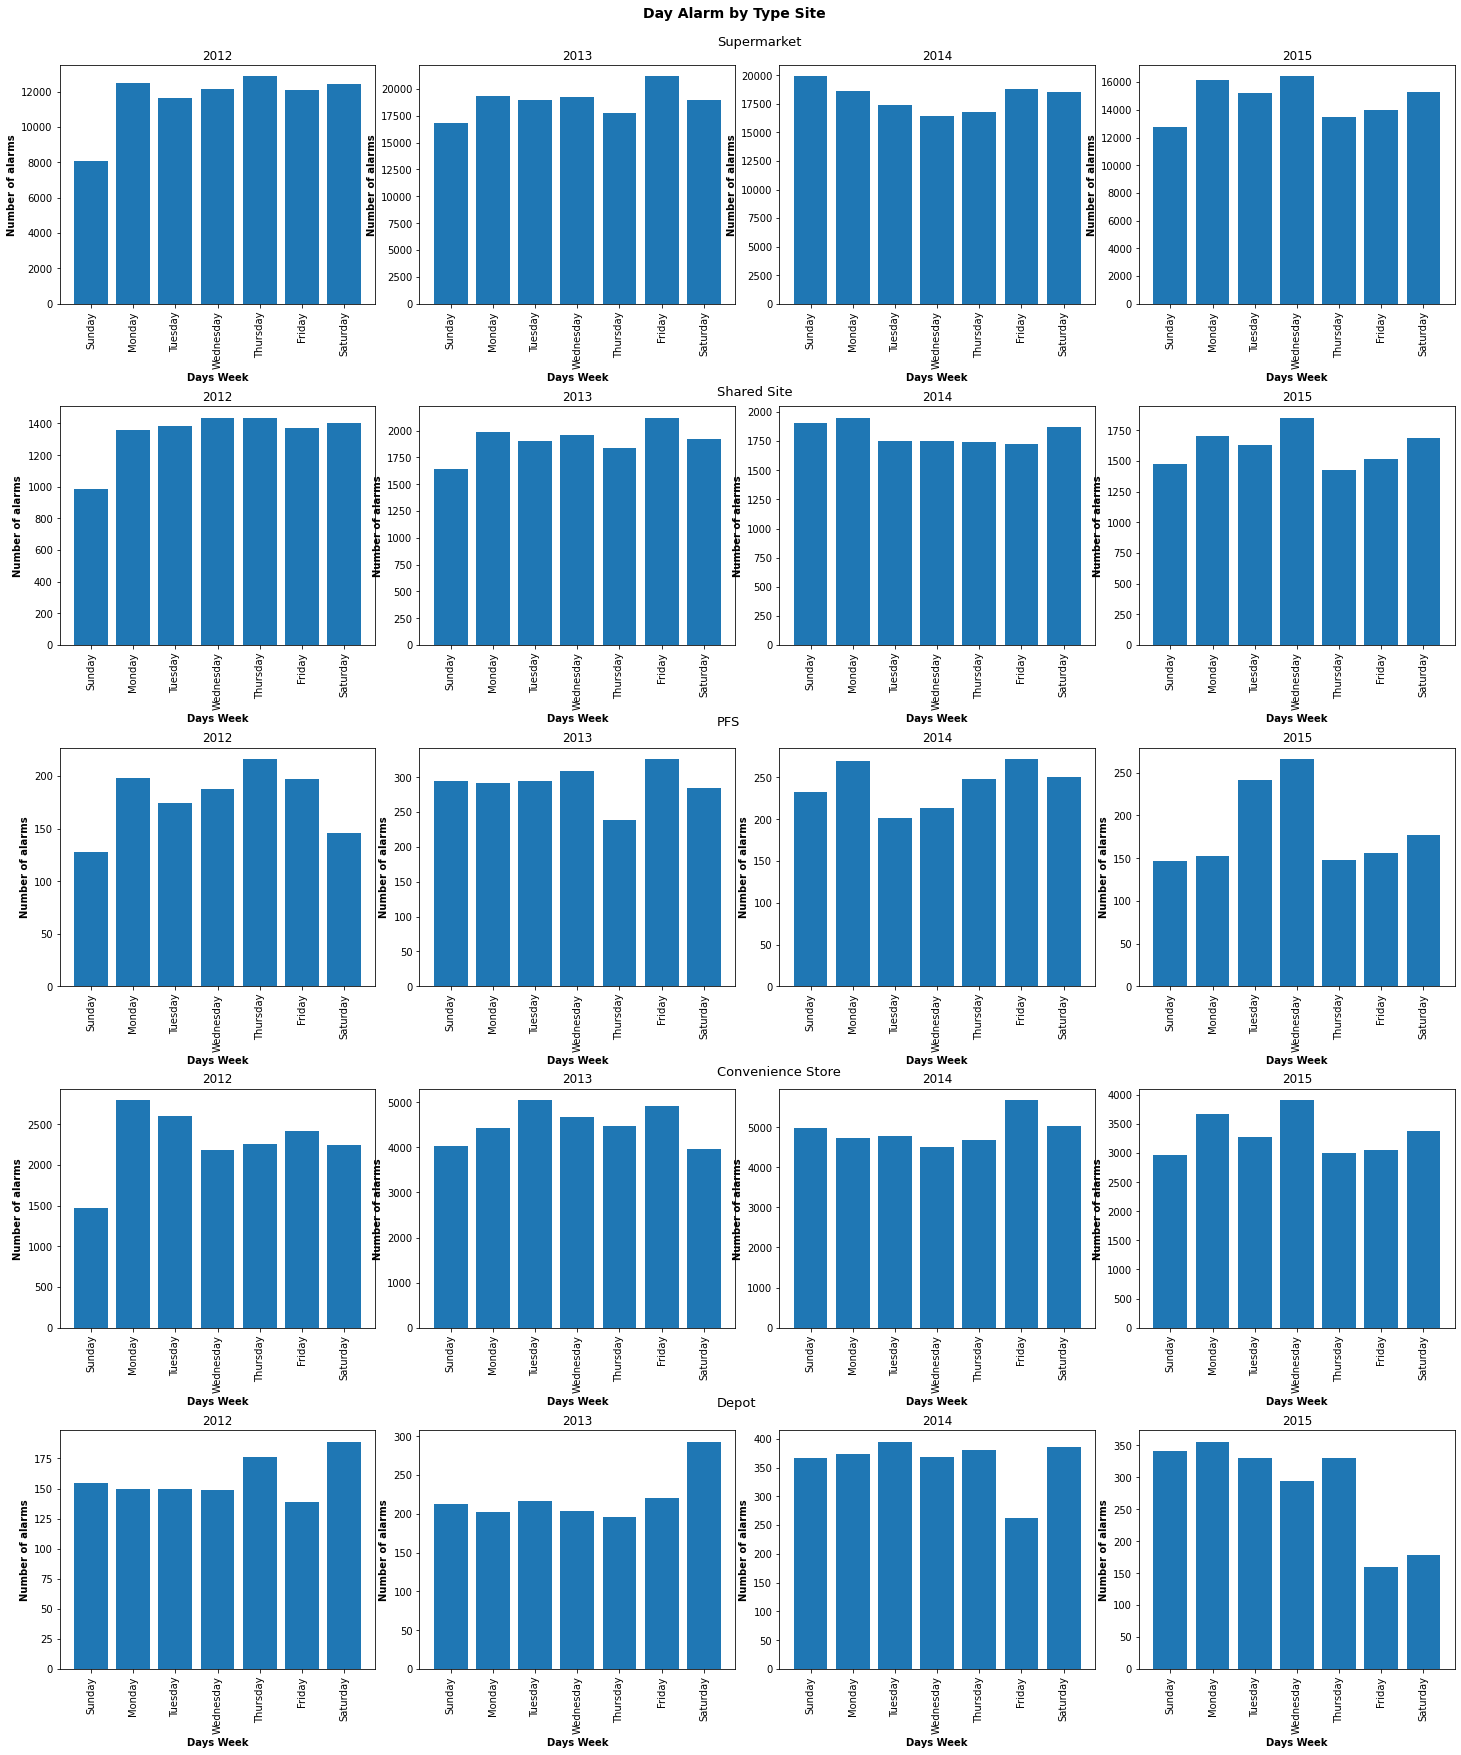

In [ ]:
dates=[['2012-01-01','2012-12-31'],['2013-01-01','2013-12-31'],['2014-01-01','2014-12-31'],['2015-01-01','2015-12-31']]
sites=df['Site Type'].unique()[:5]
fig, ax = plt.subplots(5,4,figsize=(25,27))
plt.subplots_adjust(hspace=0.43,wspace=0.14,top=0.95)
plt.suptitle('Day Alarm by Type Site',fontsize=14,weight='bold')
plt.figtext(0.49,0.96,'Supermarket',fontsize=13)
plt.figtext(0.49,0.78,'Shared Site',fontsize=13)
plt.figtext(0.49,0.61,'PFS',fontsize=13)
plt.figtext(0.49,0.43,'Convenience Store',fontsize=13)
plt.figtext(0.49,0.26,'Depot',fontsize=13)
for i in range(sites.shape[0]):
  for j in range(len(dates)):
    DF=df[(df['Date Created']>=dates[j][0])&(df['Date Created']<dates[j][1])&(df['Site Type']==sites[i])]
    new_indx=DF['Date Created Day Week'].value_counts().index.map(sorterIndex)
    ax[i,j].bar(sorter,pd.Series(data=DF['Date Created Day Week'].value_counts().values,index=new_indx).sort_index().values)
    ax[i,j].set_xticklabels(sorter,rotation=90)
    ax[i,j].set_title(dates[j][0][:4])
    ax[i,j].set_xlabel('Days Week',weight='bold')
    ax[i,j].set_ylabel('Number of alarms',weight='bold')
plt.show()

## Exploration of the behavior of alarms for every year and type site

In [ ]:
lst=[['2012-01-01','2012-12-31'],['2013-01-01','2013-12-31'],['2014-01-01','2014-12-31'],['2015-01-01','2015-12-31']]
data=np.array([])
for j in df['Site Type'].unique():
  for i in lst:
    num=df[(df['Date Created']>=i[0])&(df['Date Created']<=i[1])&(df['Site Type']==j)].shape[0]
    num=np.array([num])
    data=np.append(data,num,axis=0)

In [ ]:
data1=np.array([])
for i in lst:
  num=df[(df['Date Created']>=i[0])&(df['Date Created']<=i[1])].shape[0]
  num=np.array([num])
  data1=np.append(data1,num,axis=0)

In [ ]:
data=np.reshape(np.append(data1,data),(8,4))
labels=np.append(np.array(['All Sites']),df['Site Type'].unique())

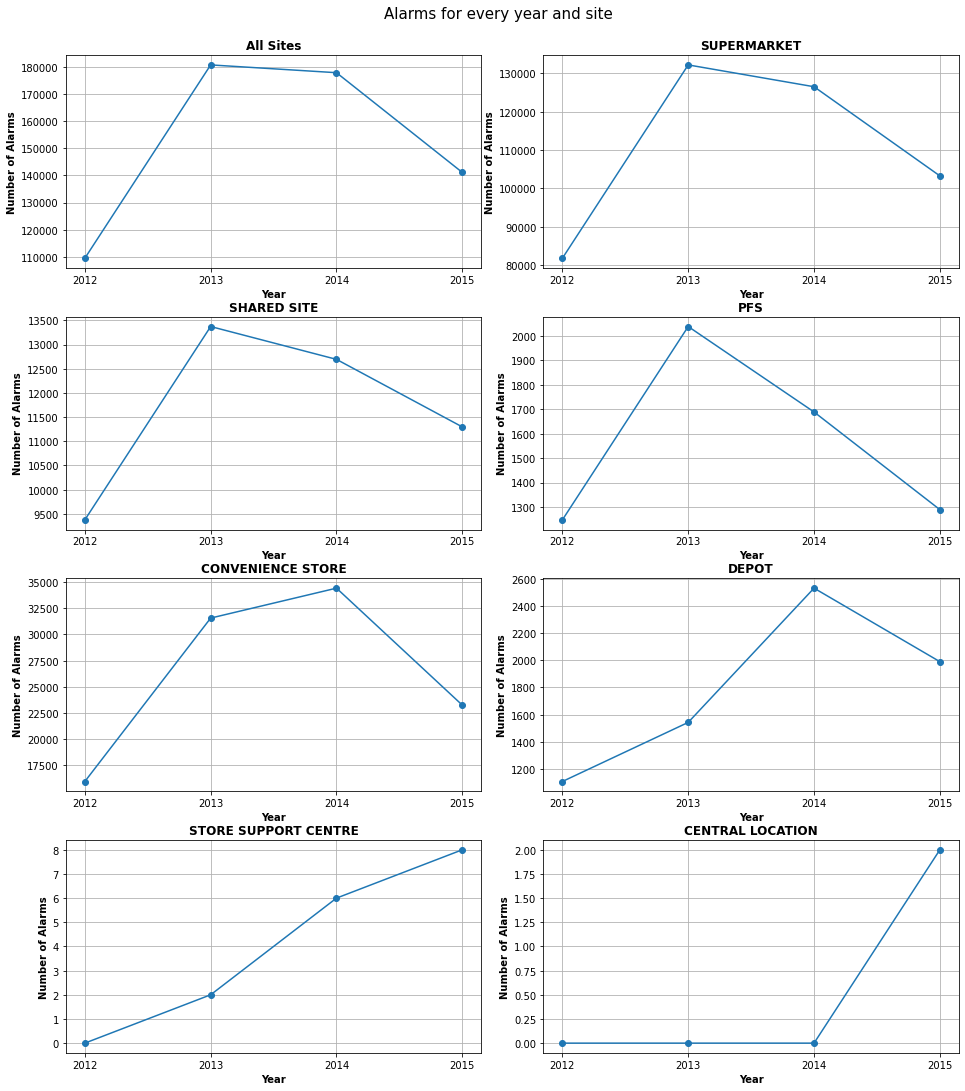

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(16,17))
plt.subplots_adjust(hspace=0.23,wspace=0.15,top=0.94)
plt.suptitle('Alarms for every year and site', fontsize=15)
for i in range(4):
  for j in range(2):
    ax[i,j].plot(np.arange(2012,2016).astype(str),data[2*i+j],'-o')
    #ax[i,j].set_xticklabels(np.arange(2012,2016))
    ax[i,j].set_title(labels[2*i+j],weight='bold')
    ax[i,j].set_xlabel('Year',weight='bold')
    ax[i,j].set_ylabel('Number of Alarms',weight='bold')
    ax[i,j].grid(True)

## Exploration of the behavior of alarms for every year and every month by type site

In [ ]:
month_1=[]
for i in range(1,10):
  month_1.append(''.join(['0',str(i)]))

month_2=[]
for i in range(10,13):
  month_2.append(str(i))

month=month_1+month_2

In [ ]:
values2012_1=[]
values2013_1=[]
values2014_1=[]
values2015_1=[]
for i in range(0,12):
  values2012_1.append("".join(['2012-',month[i],'-01']))
  values2013_1.append("".join(['2013-',month[i],'-01']))
  values2014_1.append("".join(['2014-',month[i],'-01']))
  values2015_1.append("".join(['2015-',month[i],'-01']))

values2012_2=[]
values2013_2=[]
values2014_2=[]
values2015_2=[]
for i in range(0,12):
  values2012_2.append("".join(['2012-',month[i],'-',str(pd.Period(values2012_1[i]).days_in_month)]))
  values2013_2.append("".join(['2013-',month[i],'-',str(pd.Period(values2013_1[i]).days_in_month)]))
  values2014_2.append("".join(['2014-',month[i],'-',str(pd.Period(values2014_1[i]).days_in_month)]))
  values2015_2.append("".join(['2015-',month[i],'-',str(pd.Period(values2015_1[i]).days_in_month)]))

In [ ]:
valuesm_2012=[]
valuesm_2013=[]
valuesm_2014=[]
valuesm_2015=[]
for j in df['Site Type'].unique():
  for i in range(12):
    MyVal1=df[(df['Date Created']>=values2012_1[i])&(df['Date Created']<=values2012_2[i])&(df['Site Type']==j)].shape[0]
    MyVal2=df[(df['Date Created']>=values2013_1[i])&(df['Date Created']<=values2013_2[i])&(df['Site Type']==j)].shape[0]
    MyVal3=df[(df['Date Created']>=values2014_1[i])&(df['Date Created']<=values2014_2[i])&(df['Site Type']==j)].shape[0]
    MyVal4=df[(df['Date Created']>=values2015_1[i])&(df['Date Created']<=values2015_2[i])&(df['Site Type']==j)].shape[0]
    valuesm_2012.append(MyVal1)
    valuesm_2013.append(MyVal2)
    valuesm_2014.append(MyVal3)
    valuesm_2015.append(MyVal4)

In [ ]:
valuesm_2012all=[]
valuesm_2013all=[]
valuesm_2014all=[]
valuesm_2015all=[]
for i in range(12):
  MyVal1=df[(df['Date Created']>=values2012_1[i])&(df['Date Created']<=values2012_2[i])].shape[0]
  MyVal2=df[(df['Date Created']>=values2013_1[i])&(df['Date Created']<=values2013_2[i])].shape[0]
  MyVal3=df[(df['Date Created']>=values2014_1[i])&(df['Date Created']<=values2014_2[i])].shape[0]
  MyVal4=df[(df['Date Created']>=values2015_1[i])&(df['Date Created']<=values2015_2[i])].shape[0]
  valuesm_2012all.append(MyVal1)
  valuesm_2013all.append(MyVal2)
  valuesm_2014all.append(MyVal3)
  valuesm_2015all.append(MyVal4)

In [ ]:
name_month=[]
for i in range(12):
  name_month.append(pd.Timestamp(values2012_1[i]).month_name())

In [ ]:
values_2012m=np.reshape(np.array([valuesm_2012all+valuesm_2012]),(8,12))
values_2013m=np.reshape(np.array([valuesm_2013all+valuesm_2013]),(8,12))
values_2014m=np.reshape(np.array([valuesm_2014all+valuesm_2014]),(8,12))
values_2015m=np.reshape(np.array([valuesm_2015all+valuesm_2015]),(8,12))

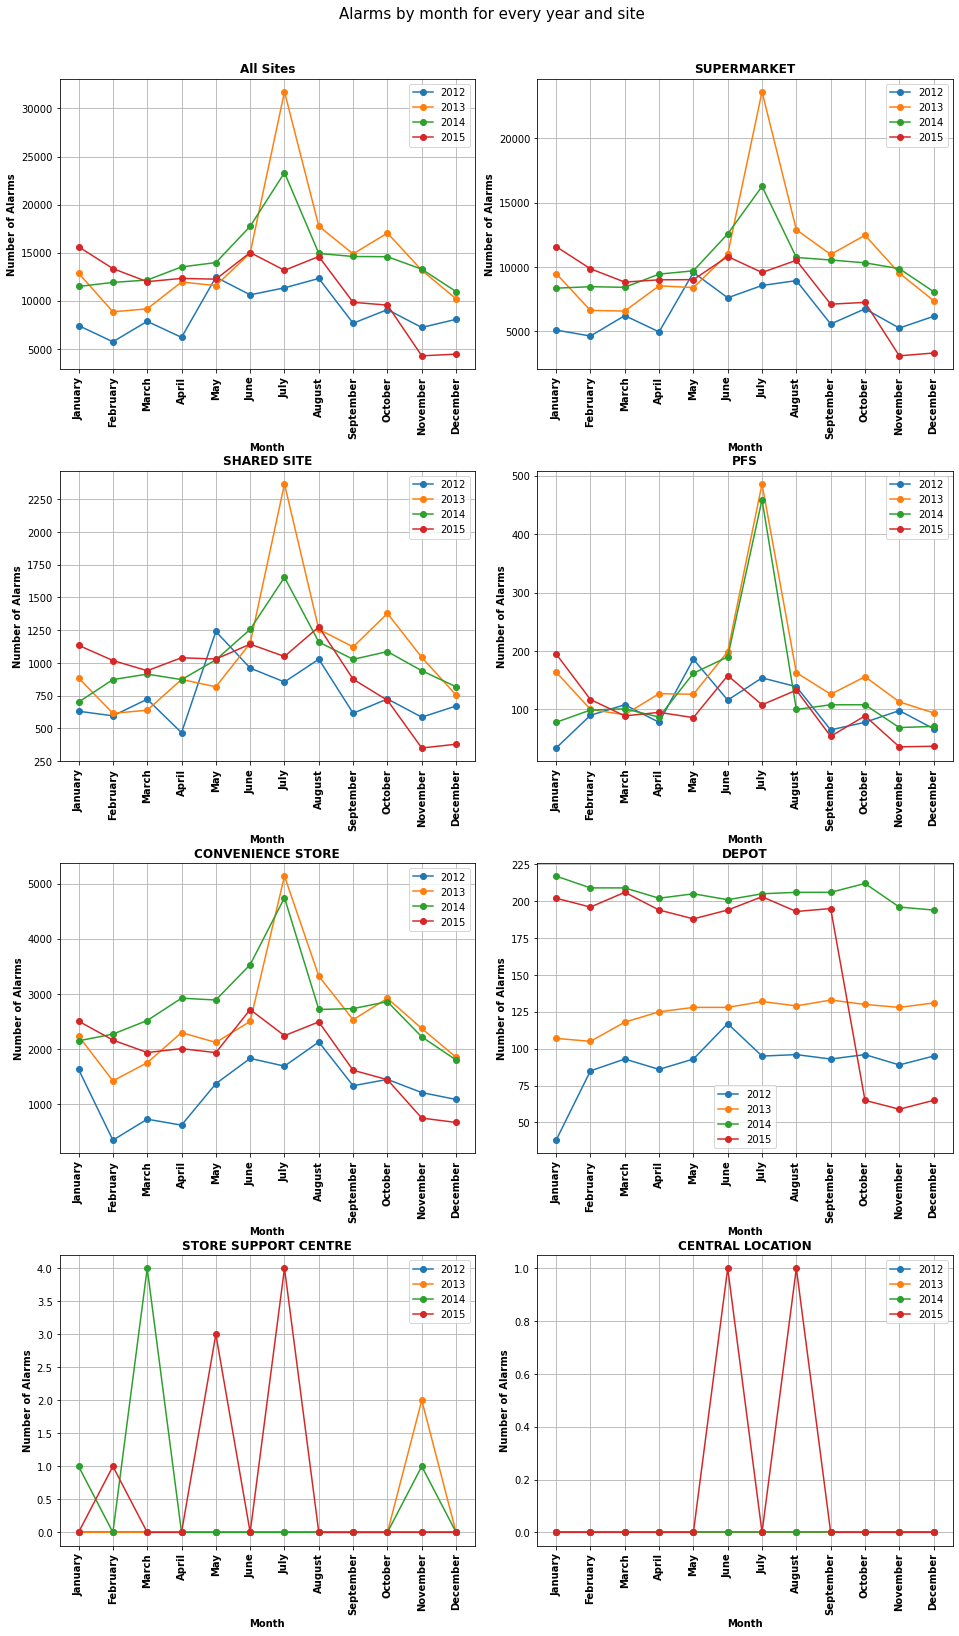

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(16,25))
plt.subplots_adjust(hspace=0.35,wspace=0.15,top=0.94)
plt.suptitle('Alarms by month for every year and site', fontsize=15)
for i in range(4):
  for j in range(2):
    ax[i,j].plot(name_month,values_2012m[2*i+j],'-o',label='2012')
    ax[i,j].plot(name_month,values_2013m[2*i+j],'-o',label='2013')
    ax[i,j].plot(name_month,values_2014m[2*i+j],'-o',label='2014')
    ax[i,j].plot(name_month,values_2015m[2*i+j],'-o',label='2015')
    ax[i,j].set_xticklabels(name_month,rotation=90,weight='bold')
    ax[i,j].set_xlabel('Month',weight='bold')
    ax[i,j].set_ylabel('Number of Alarms',weight='bold')
    ax[i,j].set_title(labels[2*i+j],weight='bold')
    ax[i,j].grid(True)
    ax[i,j].legend()

## Exploration of the behavior of alarms according to the size of the stores and year

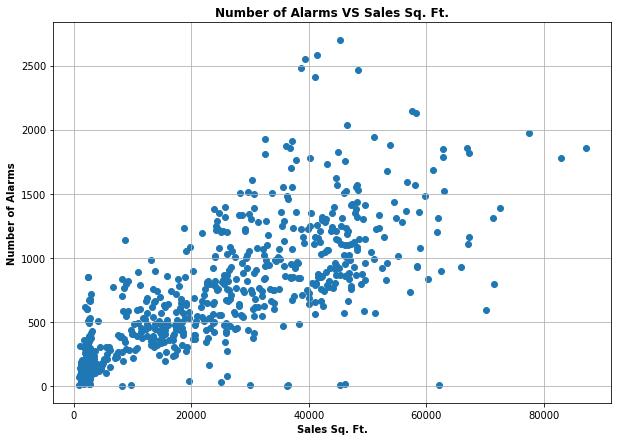

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df['Sales Sq. Ft.'].value_counts().sort_index().index,df['Sales Sq. Ft.'].value_counts().sort_index().values)
plt.xlabel('Sales Sq. Ft.',weight='bold')
plt.ylabel('Number of Alarms',weight='bold')
plt.title('Number of Alarms VS Sales Sq. Ft.',weight='bold')
plt.grid(True)
plt.show()

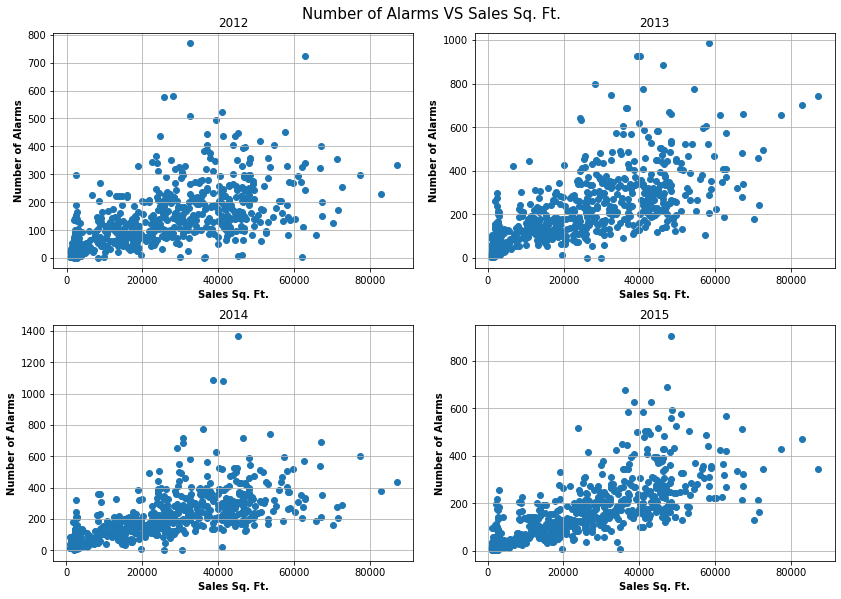

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(14,9))
plt.suptitle('Number of Alarms VS Sales Sq. Ft.', fontsize=15)
year=np.arange(2012,2017)
plt.subplots_adjust(hspace=0.24,wspace=0.17,top=0.94)
for i in range(2):
  for j in range(2):
    new_df=df[(df['Date Created']>=lst[2*i+j][0])&(df['Date Created']<=lst[2*i+j][1])]
    ax[i,j].scatter(new_df['Sales Sq. Ft.'].value_counts().sort_index().index,new_df['Sales Sq. Ft.'].value_counts().sort_index().values)
    ax[i,j].set_xlabel('Sales Sq. Ft.',weight='bold')
    ax[i,j].set_ylabel('Number of Alarms',weight='bold')
    ax[i,j].set_title(str(year[2*i+j]))
    ax[i,j].grid(True)

## Exploration of the behavior of alarms according to the size of the stores, year and type site

In [ ]:
nw=[]
MyC=np.arange(7)
for i in range(7):
  nwl=[df['Site Type'].unique()[i],MyC[i]]
  nw.append(nwl)

In [ ]:
df_stc=pd.DataFrame(data=np.array(nw),columns=['Site Type','Site Type Code'])
df=pd.merge(df,df_stc)
df['Site Type Code']=df['Site Type Code'].astype(int)

In [ ]:
colors=[]
for i in df['Sales Sq. Ft.'].value_counts().sort_index().index:
  val=df[df['Sales Sq. Ft.']==i]['Site Type Code'].values[0]
  colors.append(val)

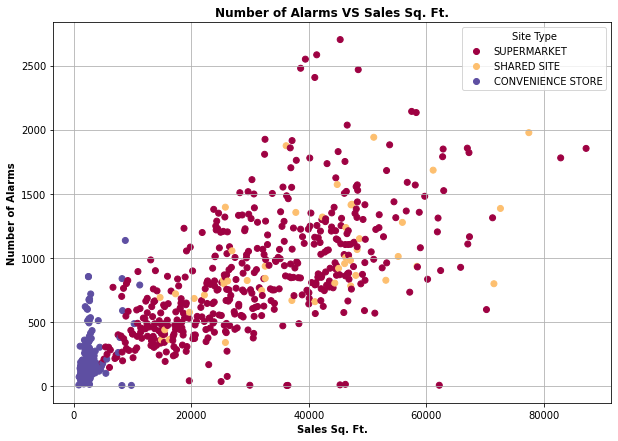

In [ ]:
plt.figure(figsize=(10,7))
sc_plt=plt.scatter(df['Sales Sq. Ft.'].value_counts().sort_index().index,df['Sales Sq. Ft.'].value_counts().sort_index().values,c=colors,cmap=plt.cm.Spectral)
plt.legend(handles=sc_plt.legend_elements()[0],labels=['SUPERMARKET', 'SHARED SITE', 'CONVENIENCE STORE','PFS', 'DEPOT',\
                                                       'STORE SUPPORT CENTRE','CENTRAL LOCATION'],title='Site Type')
plt.ylabel('Number of Alarms',weight='bold')
plt.xlabel('Sales Sq. Ft.',weight='bold')
plt.title('Number of Alarms VS Sales Sq. Ft.',weight='bold')
plt.grid(True)
plt.show()

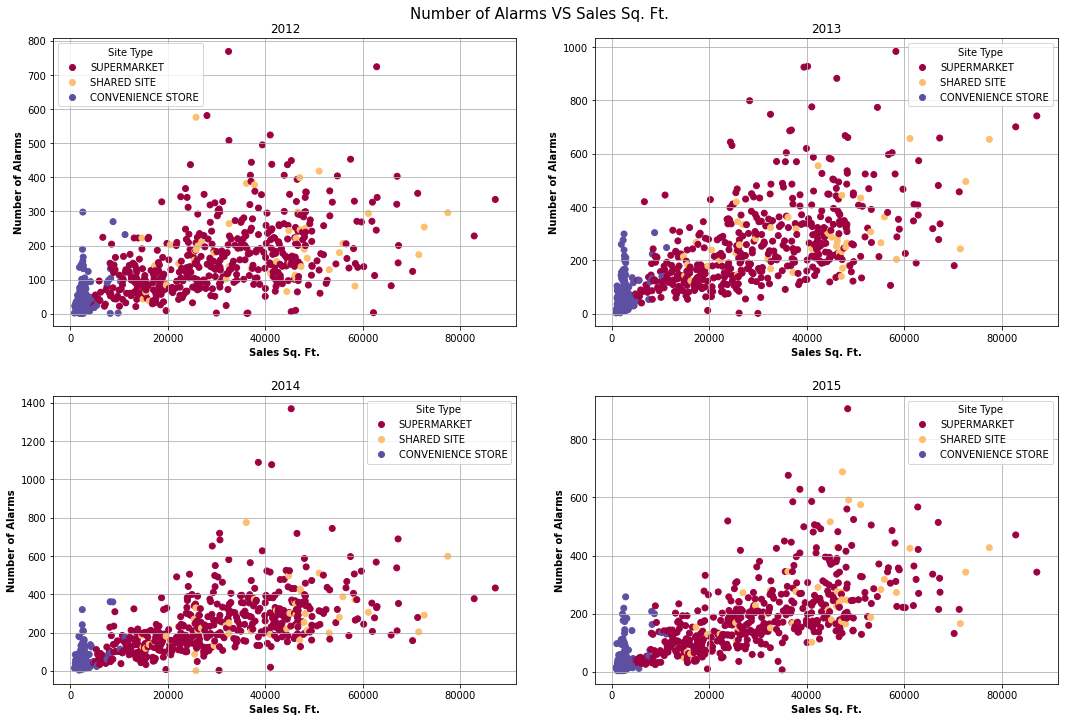

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(18,11))
plt.suptitle('Number of Alarms VS Sales Sq. Ft.', fontsize=15)
year=np.arange(2012,2017)
plt.subplots_adjust(hspace=0.24,wspace=0.17,top=0.94)
for i in range(2):
  for j in range(2):
    new_df=df[(df['Date Created']>=lst[2*i+j][0])&(df['Date Created']<=lst[2*i+j][1])]
    colors=[]
    for k in new_df['Sales Sq. Ft.'].value_counts().sort_index().index:
      val=new_df[new_df['Sales Sq. Ft.']==k]['Site Type Code'].values[0]
      colors.append(val)
    ax[i,j].scatter(new_df['Sales Sq. Ft.'].value_counts().sort_index().index,new_df['Sales Sq. Ft.'].value_counts().sort_index().values,c=colors,cmap=plt.cm.Spectral)
    ax[i,j].legend(handles=sc_plt.legend_elements()[0],labels=['SUPERMARKET', 'SHARED SITE', 'CONVENIENCE STORE','PFS', 'DEPOT',\
                                                       'STORE SUPPORT CENTRE','CENTRAL LOCATION'],title='Site Type')
    ax[i,j].set_xlabel('Sales Sq. Ft.',weight='bold')
    ax[i,j].set_ylabel('Number of Alarms',weight='bold')
    ax[i,j].set_title(str(year[2*i+j]))
    ax[i,j].grid(True)

## Exploration relation between number of alarms and asset type

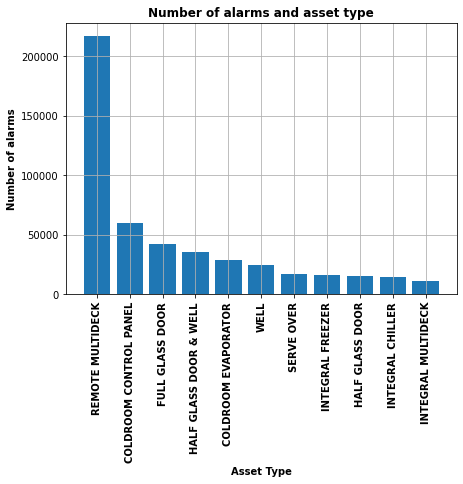

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(df['Asset Type'].value_counts().nlargest(11).index,df['Asset Type'].value_counts().nlargest(11).values)
plt.xticks(rotation=90,weight='bold')
plt.ylabel('Number of alarms',weight='bold')
plt.xlabel('Asset Type',weight='bold')
plt.title('Number of alarms and asset type',weight='bold')
plt.grid(True)
plt.show()

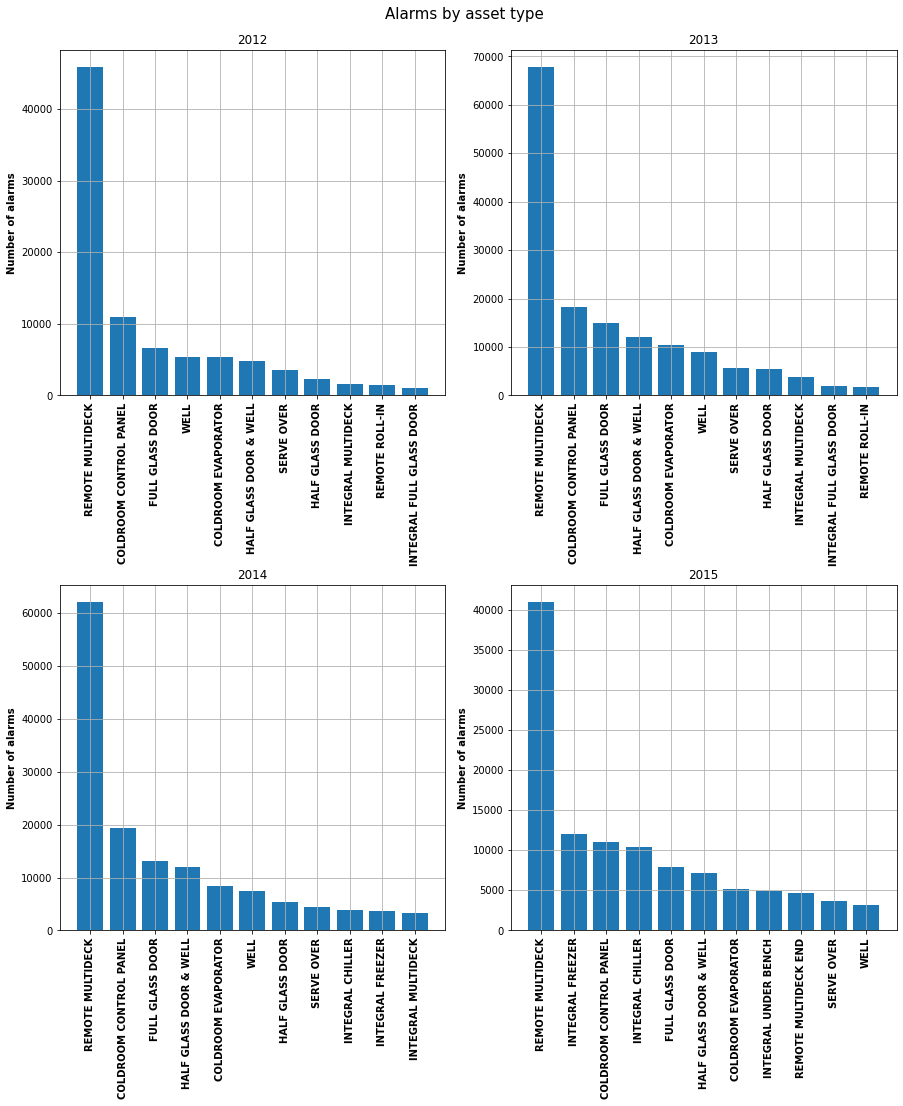

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(15,15))
plt.subplots_adjust(hspace=0.55,wspace=0.17,top=0.94)
plt.suptitle('Alarms by asset type', fontsize=15)
year=np.arange(2012,2017)
for i in range(2):
  for j in range(2):
    new_df=df[(df['Date Created']>=lst[2*i+j][0])&(df['Date Created']<=lst[2*i+j][1])]
    ax[i,j].bar(new_df['Asset Type'].value_counts().nlargest(11).index,new_df['Asset Type'].value_counts().nlargest(11).values)
    ax[i,j].set_xticklabels(new_df['Asset Type'].value_counts().nlargest(11).index,rotation=90,weight='bold')
    ax[i,j].set_ylabel('Number of alarms',weight='bold')
    ax[i,j].set_title(str(year[2*i+j]))
    ax[i,j].grid(True)

## Exploration relation between number of alarms, asset type and site type

In [ ]:
indx1=df['Asset Type'].value_counts().nlargest(12).index
indx2=df['Site Type'].value_counts().index

In [ ]:
nlst=np.array([])
for j in indx1:
  for i in indx2:
    val=df[(df['Asset Type']==j)&(df['Site Type']==i)]['Site Type'].value_counts().values
    if val.shape[0]==0:
      val=np.array([0])
    nlst=np.append(nlst,val)

In [ ]:
df_1=pd.DataFrame(data=np.reshape(nlst,(indx1.shape[0],indx2.shape[0])),columns=indx2)
df_2=pd.DataFrame(indx1,columns=['Site Type'])
df_all=df_2.join(df_1)

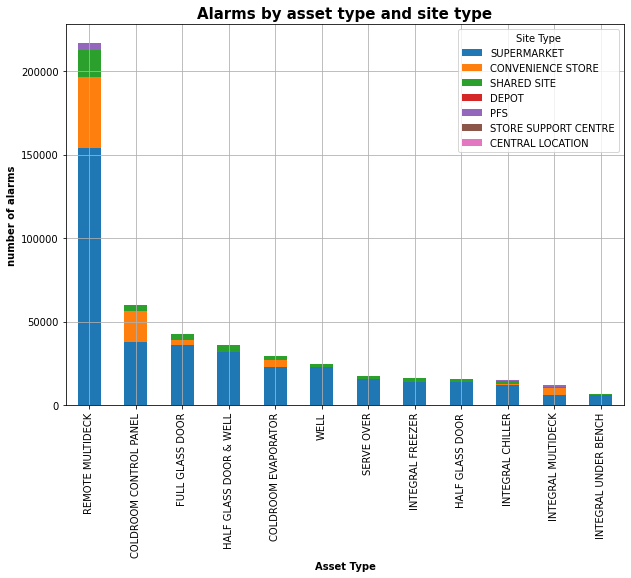

In [ ]:
df_all.plot(x='Site Type',kind='bar', stacked=True,figsize=(10,7))
plt.legend(title='Site Type')
plt.xlabel('Asset Type',weight='bold')
plt.ylabel('number of alarms',weight='bold')
plt.title('Alarms by asset type and site type', fontsize=15,weight='bold')
plt.grid(True)
plt.show()

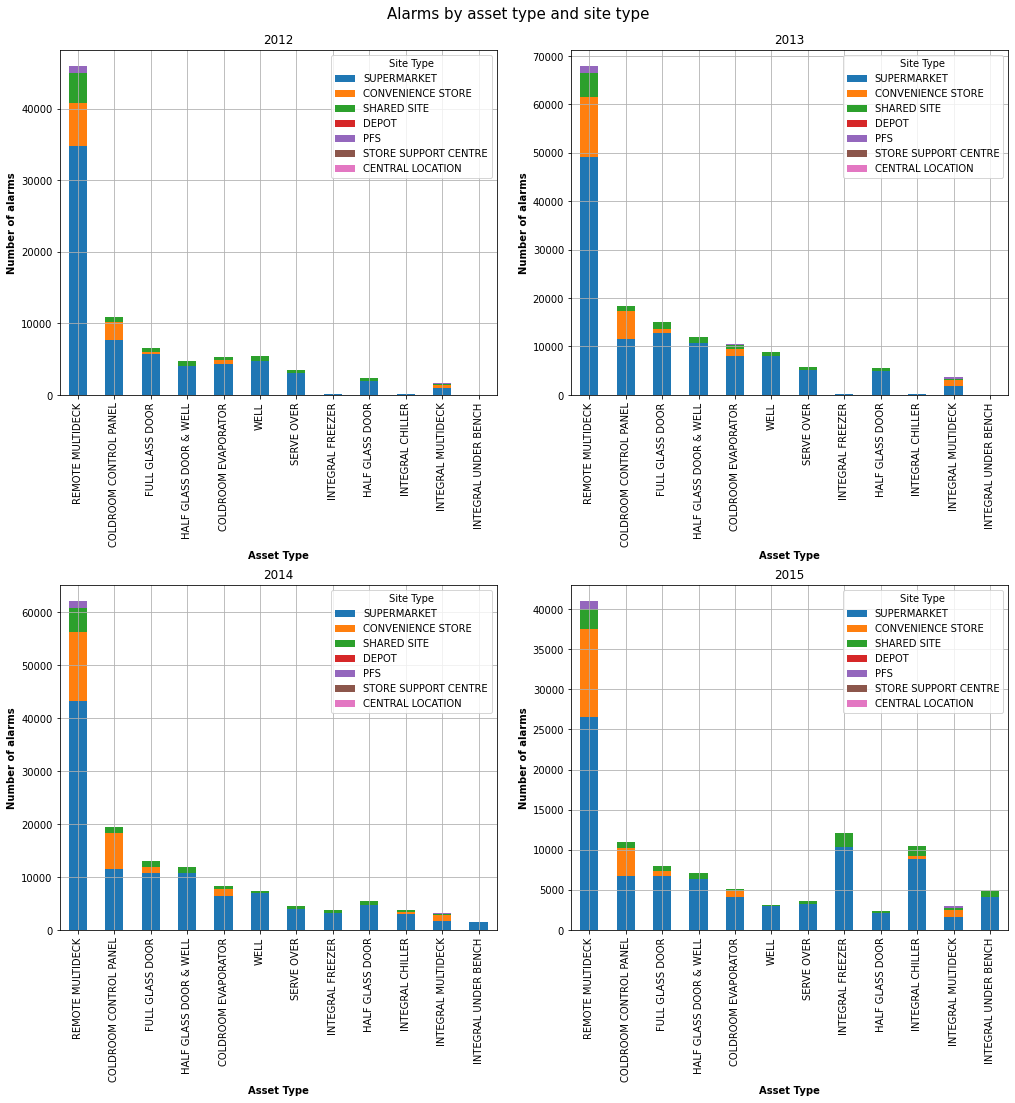

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(17,15))
plt.suptitle('Alarms by asset type and site type', fontsize=15)
plt.subplots_adjust(hspace=0.55,wspace=0.17,top=0.94)
for h in range(2):
  for k in range(2):
    new_df=df[(df['Date Created']>=lst[2*h+k][0])&(df['Date Created']<=lst[2*h+k][1])]
    nlst=np.array([])
    for j in indx1:
      for i in indx2:
        val=new_df[(new_df['Asset Type']==j)&(new_df['Site Type']==i)]['Site Type'].value_counts().values
        if val.shape[0]==0:
          val=np.array([0])
        nlst=np.append(nlst,val)
    df_1=pd.DataFrame(data=np.reshape(nlst,(indx1.shape[0],indx2.shape[0])),columns=indx2)
    df_2=pd.DataFrame(indx1,columns=['Site Type'])
    df_all=df_2.join(df_1)
    df_all.plot(x='Site Type',kind='bar', stacked=True, title=year[2*h+k], ax=axes[h,k])
    axes[h,k].set_ylabel('Number of alarms',weight='bold')
    axes[h,k].legend(title='Site Type')
    axes[h,k].set_xlabel('Asset Type',weight='bold')
    axes[h,k].grid(True)

## Exploration relation between number of alarms, problem type and site type

In [ ]:
indx1=df['Problem Type Name'].value_counts().nlargest(20).index
indx2=df['Site Type'].value_counts().index

In [ ]:
nlst=np.array([])
for j in indx1:
  for i in indx2:
    val=df[(df['Problem Type Name']==j)&(df['Site Type']==i)]['Problem Type Name'].value_counts().values
    if val.shape[0]==0:
      val=np.array([0])
    nlst=np.append(nlst,val)

In [ ]:
df_1=pd.DataFrame(data=np.reshape(nlst,(indx1.shape[0],indx2.shape[0])),columns=indx2)
df_2=pd.DataFrame([indx1[i][:20] for i in range(indx1.shape[0])],columns=['Problem Type Name'])
df_all=df_2.join(df_1)

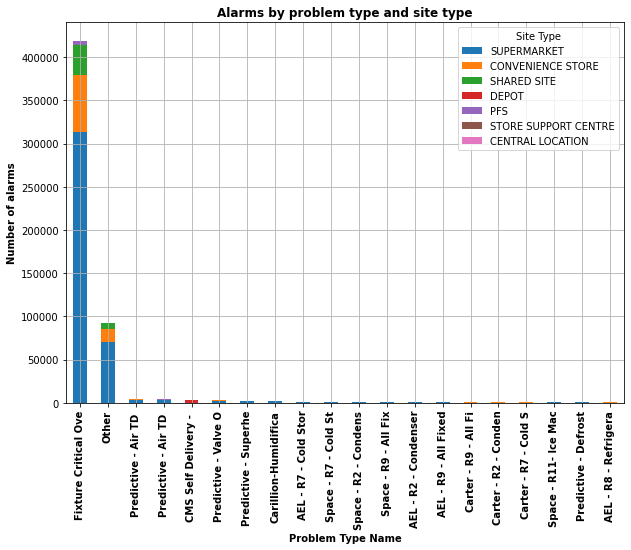

In [ ]:
df_all.plot(x='Problem Type Name',kind='bar', stacked=True,figsize=(10,7))
plt.legend(title='Site Type')
plt.xlabel('Problem Type Name',weight='bold')
plt.ylabel('Number of alarms',weight='bold')
plt.title('Alarms by problem type and site type',weight='bold')
plt.xticks(weight='bold')
plt.grid(True)
plt.show()

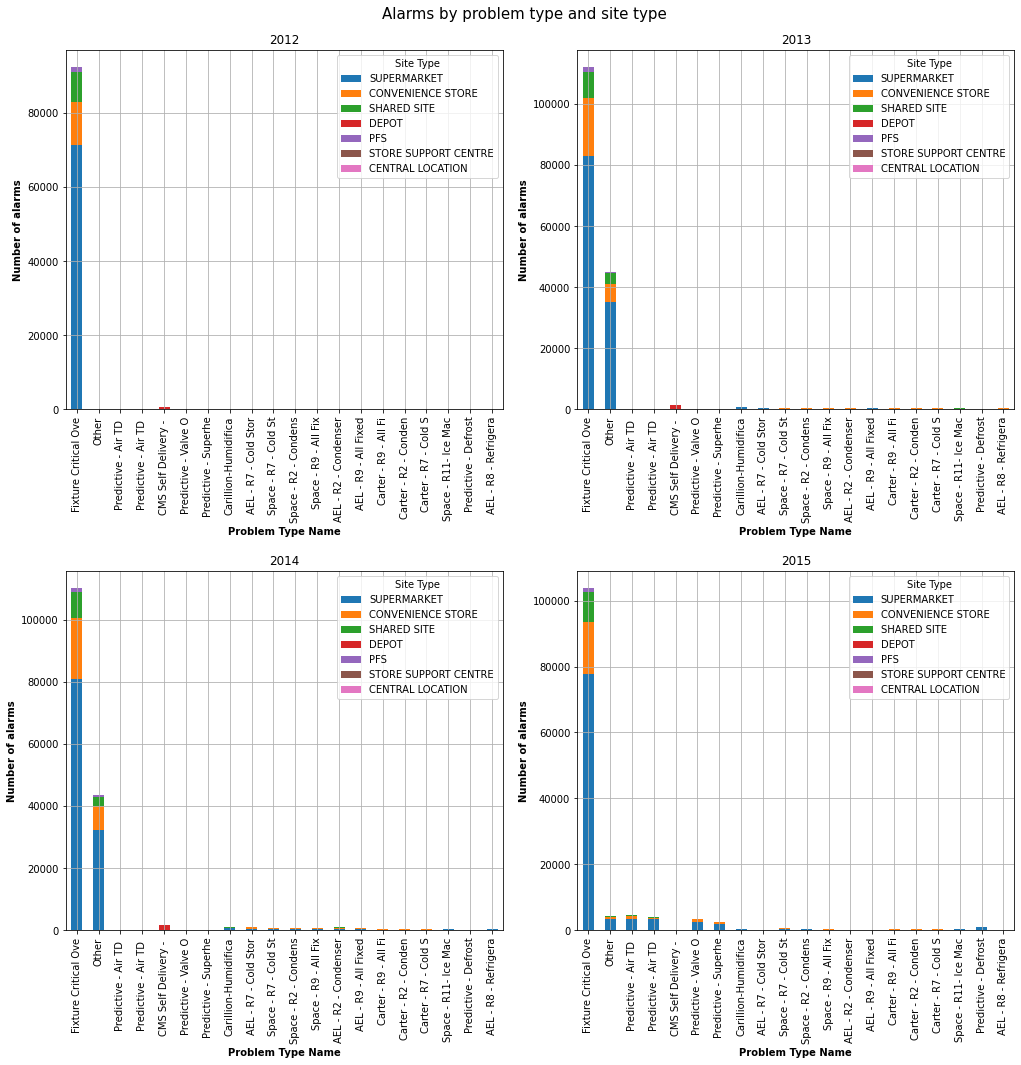

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(17,15))
plt.suptitle('Alarms by problem type and site type', fontsize=15)
plt.subplots_adjust(hspace=0.45,wspace=0.17,top=0.94)
for h in range(2):
  for k in range(2):
    new_df=df[(df['Date Created']>=lst[2*h+k][0])&(df['Date Created']<=lst[2*h+k][1])]
    nlst=np.array([])
    for j in indx1:
      for i in indx2:
        val=new_df[(new_df['Problem Type Name']==j)&(new_df['Site Type']==i)]['Site Type'].value_counts().values
        if val.shape[0]==0:
          val=np.array([0])
        nlst=np.append(nlst,val)
    df_1=pd.DataFrame(data=np.reshape(nlst,(indx1.shape[0],indx2.shape[0])),columns=indx2)
    df_2=pd.DataFrame([indx1[i][:20] for i in range(indx1.shape[0])],columns=['Problem Type Name'])
    df_all=df_2.join(df_1)
    df_all.plot(x='Problem Type Name',kind='bar', stacked=True, title=year[2*h+k], ax=axes[h,k])
    axes[h,k].set_ylabel('Number of alarms',weight='bold')
    axes[h,k].legend(title='Site Type')
    axes[h,k].set_xlabel('Problem Type Name',weight='bold')
    axes[h,k].grid(True)

bold text##Exploration relation between number of alarms and provider

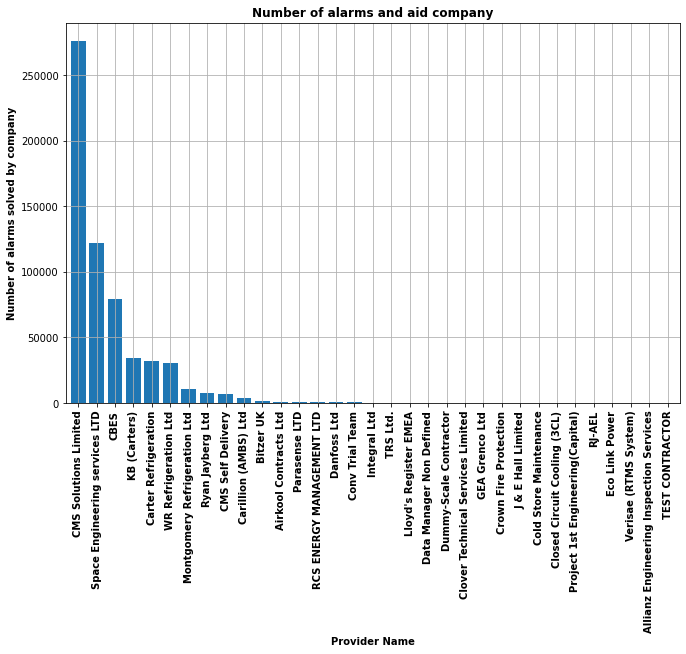

In [ ]:
plt.figure(figsize=(11,7))
plt.bar(df['Provider Name'].value_counts(dropna=False).index,df['Provider Name'].value_counts(dropna=False).values)
plt.xticks(rotation=90,weight='bold')
plt.title('Number of alarms and aid company',fontsize=12,weight='bold')
plt.xlabel('Provider Name',weight='bold')
plt.ylabel('Number of alarms solved by company',weight='bold')
plt.margins(x=0.008)
plt.grid(True)
plt.show()

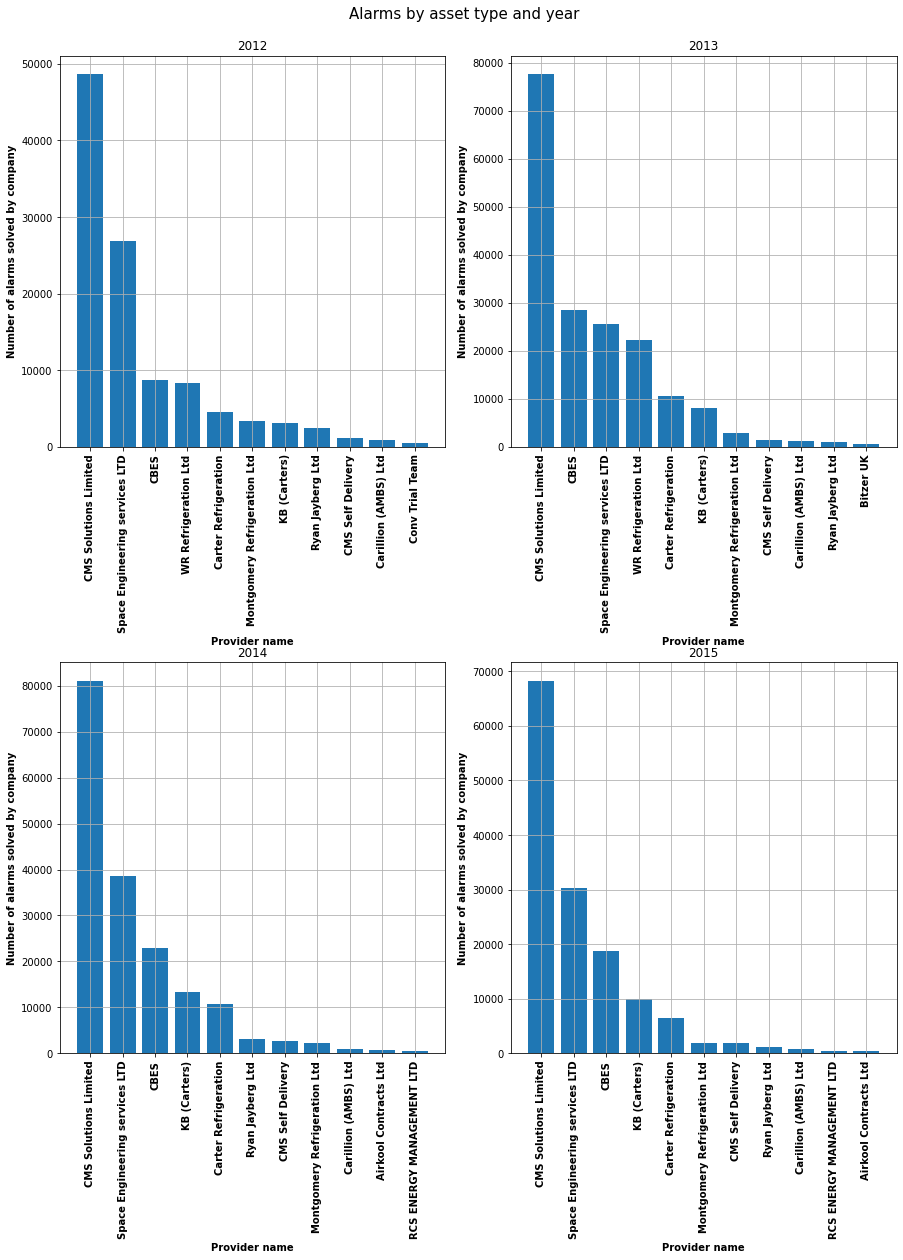

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(15,17))
plt.subplots_adjust(hspace=0.55,wspace=0.17,top=0.94)
plt.suptitle('Alarms by asset type and year', fontsize=15)
year=np.arange(2012,2017)
for i in range(2):
  for j in range(2):
    new_df=df[(df['Date Created']>=lst[2*i+j][0])&(df['Date Created']<=lst[2*i+j][1])]
    ax[i,j].bar(new_df['Provider Name'].value_counts().nlargest(11).index,new_df['Provider Name'].value_counts().nlargest(11).values)
    ax[i,j].set_xticklabels(new_df['Provider Name'].value_counts().nlargest(11).index,rotation=90,weight='bold')
    ax[i,j].set_ylabel('Number of alarms solved by company',weight='bold')
    ax[i,j].set_xlabel('Provider name',weight='bold')
    ax[i,j].set_title(str(year[2*i+j]))
    ax[i,j].grid(True)

## Classification shops for number of alarms

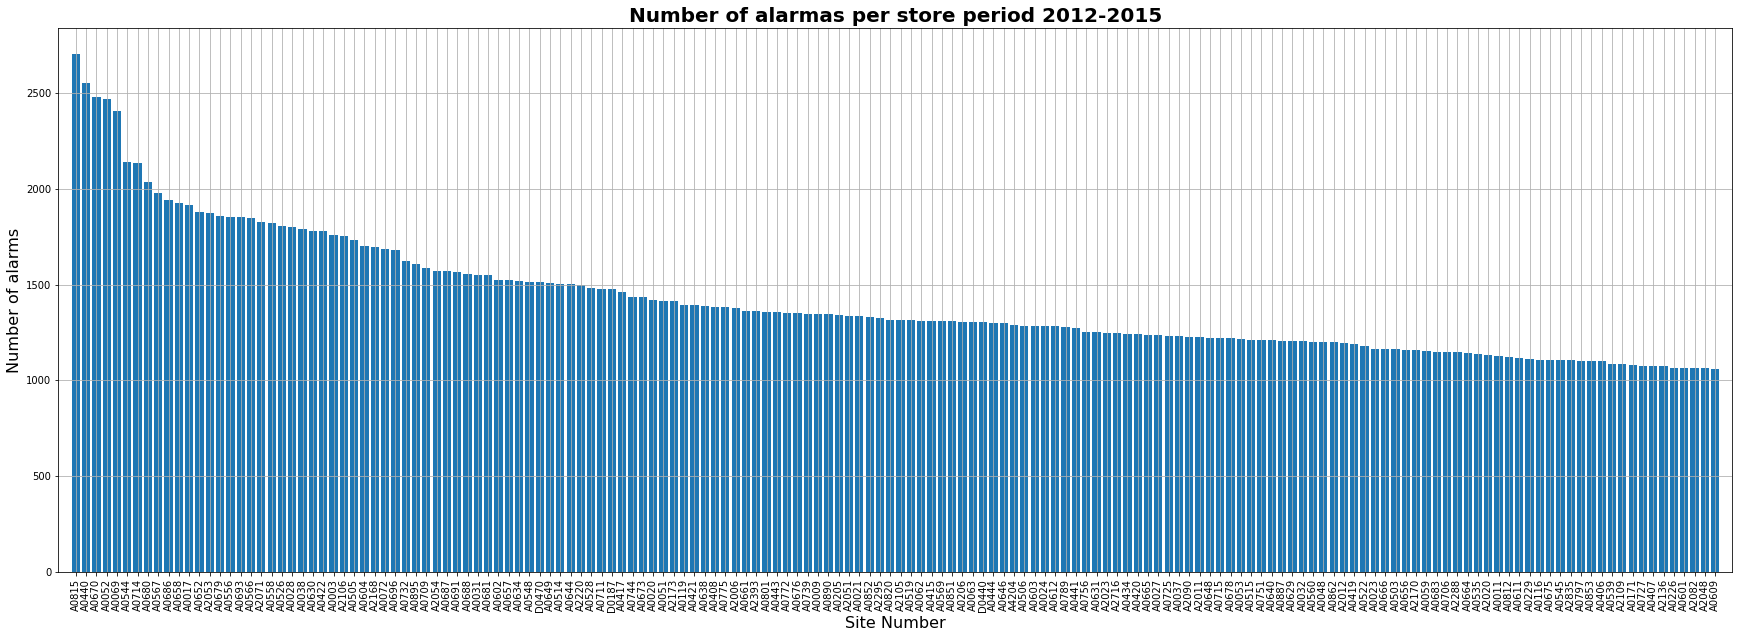

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(df['Site Number'].value_counts()[:160].index,df['Site Number'].value_counts()[:160].values)
plt.xticks(rotation=90)
plt.grid(True)
plt.margins(x=0.008)
plt.xlabel('Site Number',fontsize=16)
plt.ylabel('Number of alarms', fontsize=16)
plt.title('Number of alarmas per store period 2012-2015',fontsize=20,weight='bold')
plt.show()

In [ ]:
print('The store with major number of alarms is',df['Site Number'].value_counts().nlargest(1).index[0],', the number of alarms are',df['Site Number'].value_counts().nlargest(1).values[0])

The store with major number of alarms is A0815 , the number of alarms are 2703


In [ ]:
print('The store with minor number of alarms is',df['Site Number'].value_counts().nsmallest(1).index[0],', the number of alarms are',df['Site Number'].value_counts().nsmallest(1).values[0])

The store with minor number of alarms is P2059 , the number of alarms are 1


In [ ]:
Site_Number_Ordering=df['Site Number'].value_counts().index

In [ ]:
SizeSite=[df[df['Site Number']==sto]['Sales Sq. Ft.'].values[0] for sto in Site_Number_Ordering]

In [ ]:
True_values=~np.isnan(np.array(SizeSite))

In [ ]:
number_alarms_slct=df['Site Number'].value_counts().values[True_values]
size_site_slct=np.array(SizeSite)[True_values]
site_number_slct=Site_Number_Ordering[True_values]

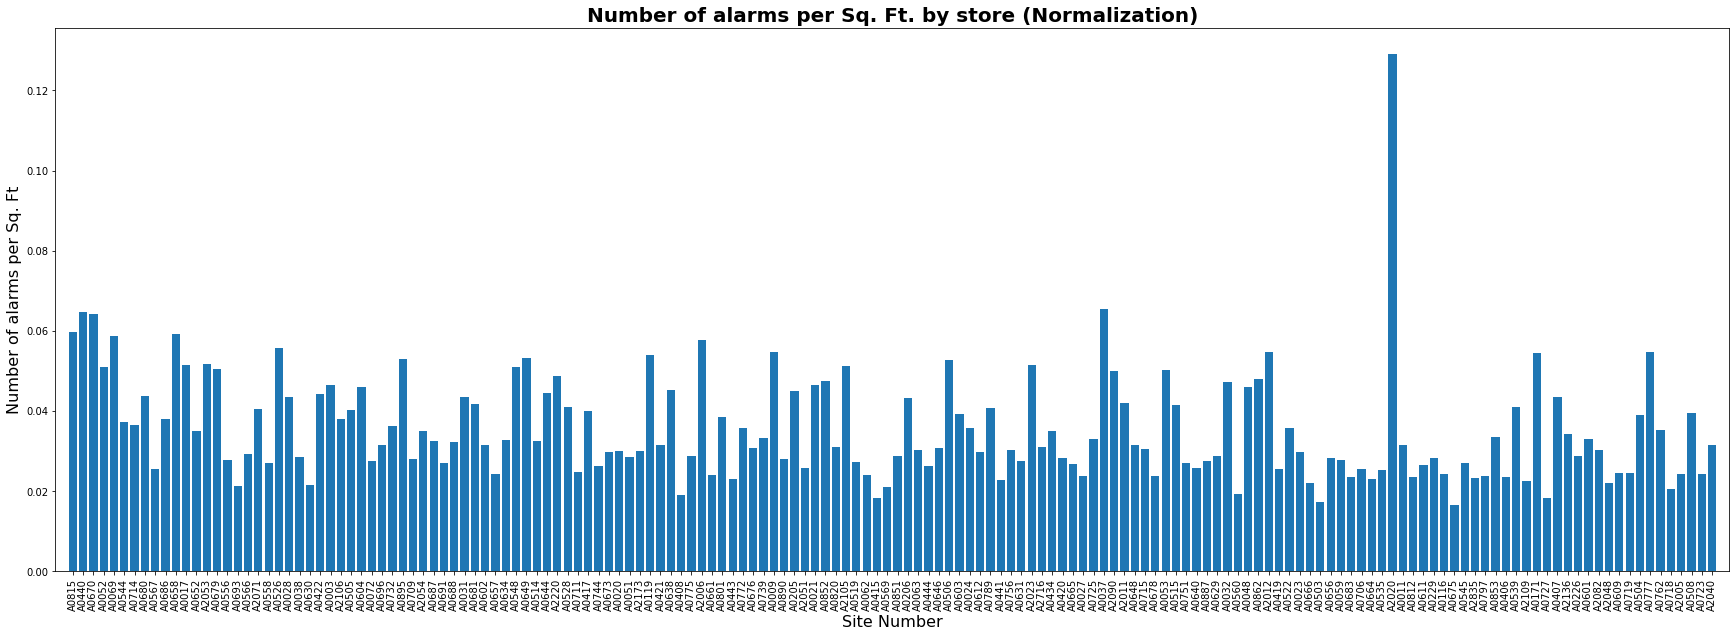

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(site_number_slct[:160],(number_alarms_slct/size_site_slct)[:160])
plt.xticks(rotation=90)
plt.margins(x=0.008)
plt.xlabel('Site Number',fontsize=16)
plt.ylabel('Number of alarms per Sq. Ft', fontsize=16)
plt.title('Number of alarms per Sq. Ft. by store (Normalization)', weight='bold', fontsize=20)
plt.show()

In [ ]:
max_val=np.max((number_alarms_slct/size_site_slct))
min_val=np.min((number_alarms_slct/size_site_slct))

In [ ]:
max_position=np.where((number_alarms_slct/size_site_slct)==max_val)[0][0]
min_position=np.where((number_alarms_slct/size_site_slct)==min_val)[0][0]

In [ ]:
print('The store with major number of alarms per Sq. Ft is',site_number_slct[max_position],', the number of alarms are',max_val,'/Sq. Ft.')

The store with major number of alarms per Sq. Ft is A4026 , the number of alarms are 0.3390438247011952 /Sq. Ft.


In [ ]:
print('The store with minor number of alarms per Sq. Ft is',site_number_slct[min_position],', the number of alarms are',min_val,'/Sq. Ft.')

The store with minor number of alarms per Sq. Ft is A0738 , the number of alarms are 2.758772897815052e-05 /Sq. Ft.
